<a href="https://colab.research.google.com/github/Tej-55/SAiDL-Summer-Assignment-2023-Core_ML/blob/main/Variations_of_Softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time

In [ ]:
# First load the CIFAR-100 from tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

169001437/169001437 [==============================] - 13s 0us/step


In [ ]:
# Scale pixel value to [0,1] float values
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [ ]:
# Convert labels to OHE
y_train = tf.keras.utils.to_categorical(y_train, num_classes=100)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=100)

In [ ]:

class TimeHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        super(TimeHistory, self).__init__()
        self.epoch_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        mean_epoch_time = np.mean(self.epoch_times)
        logs["mean_epoch_time"] = mean_epoch_time

# Using Normal Softmax

In [ ]:
# Make the model (I have used functional API)
def functional_model():
  inputs = layers.Input(shape=(32, 32, 3))
  x = layers.Conv2D(32, (3, 3), activation="relu")(inputs)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Conv2D(64, (3, 3), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation="relu")(x)
  outputs = layers.Dense(100, activation="softmax")(x)
  return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compile and train
model = functional_model()
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test), callbacks=[TimeHistory()])

Epoch 1/10
782/782 [==============================] - 16s 6ms/step - loss: 3.7776 - accuracy: 0.1308 - val_loss: 3.3117 - val_accuracy: 0.2038 - mean_epoch_time: 15.6154
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 3.0783 - accuracy: 0.2479 - val_loss: 2.9620 - val_accuracy: 0.2827 - mean_epoch_time: 10.2419
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 2.7778 - accuracy: 0.3108 - val_loss: 2.7890 - val_accuracy: 0.3092 - mean_epoch_time: 8.3283
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 2.5768 - accuracy: 0.3529 - val_loss: 2.6342 - val_accuracy: 0.3417 - mean_epoch_time: 7.3006
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 2.4178 - accuracy: 0.3844 - val_loss: 2.6539 - val_accuracy: 0.3361 - mean_epoch_time: 6.8425
Epoch 6/10
782/782 [==============================] - 4s 6ms/step - loss: 2.2982 - accuracy: 0.4086 - val_loss: 2.5202 - val_accuracy: 0.3674 - mean_epoch_ti

In [ ]:
# Predict the classes of the test set
y_pred = model.predict(x_test)
y_pred_classes = tf.argmax(y_pred, axis=1)
y_true_classes = tf.argmax(y_test, axis=1)

# Compute evaluation metrics
acc = accuracy_score(y_true_classes, y_pred_classes)
prec = precision_score(y_true_classes, y_pred_classes, average='micro')
rec = recall_score(y_true_classes, y_pred_classes, average='micro')
f1 = f1_score(y_true_classes, y_pred_classes, average='micro')
cm = confusion_matrix(y_true_classes, y_pred_classes)

313/313 [==============================] - 1s 2ms/step


In [ ]:
#average training time per epoch
history.history['mean_epoch_time'][-1] 

5.684497356414795

In [ ]:
acc, prec, rec, f1

(0.3839, 0.3839, 0.3839, 0.3839)

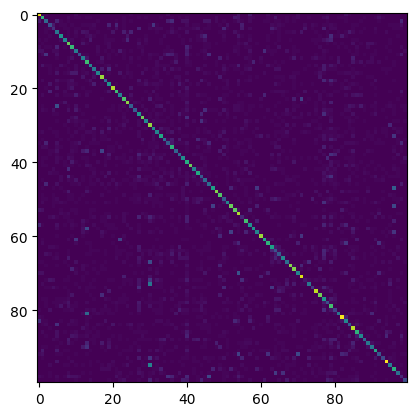

In [ ]:
plt.imshow(cm)

# Using Gumbel Softmax

In [ ]:
# First we define the gumbel_softmax
def gumbel_softmax(logits, temperature, hard=False):
    # Generate Gumbel noise
    noise = -tf.math.log(-tf.math.log(tf.random.uniform(tf.shape(logits), minval=1e-10, maxval=1.0)))

    # Add noise to logits
    y = logits + noise / temperature

    # Apply softmax
    y = tf.nn.softmax(y, axis=-1)
    return y

In [ ]:
# Make the model (I have used functional API)
def functional_model():
  inputs = layers.Input(shape=(32, 32, 3))
  x = layers.Conv2D(32, (3, 3), activation="relu")(inputs)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Conv2D(64, (3, 3), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation="relu")(x)
  outputs = layers.Dense(100, activation=lambda x: gumbel_softmax(x, 10))(x)
  return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compile and train
model = functional_model()
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test), callbacks=[TimeHistory()])

Epoch 1/10
782/782 [==============================] - 7s 7ms/step - loss: 3.8432 - accuracy: 0.1206 - val_loss: 3.3987 - val_accuracy: 0.1941 - mean_epoch_time: 7.1762
Epoch 2/10
782/782 [==============================] - 4s 6ms/step - loss: 3.1468 - accuracy: 0.2389 - val_loss: 3.0201 - val_accuracy: 0.2639 - mean_epoch_time: 5.7423
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 2.8356 - accuracy: 0.2983 - val_loss: 2.8479 - val_accuracy: 0.2994 - mean_epoch_time: 5.3552
Epoch 4/10
782/782 [==============================] - 5s 7ms/step - loss: 2.6346 - accuracy: 0.3383 - val_loss: 2.7539 - val_accuracy: 0.3209 - mean_epoch_time: 5.2921
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 2.4770 - accuracy: 0.3722 - val_loss: 2.6567 - val_accuracy: 0.3382 - mean_epoch_time: 5.1869
Epoch 6/10
782/782 [==============================] - 5s 7ms/step - loss: 2.3502 - accuracy: 0.3984 - val_loss: 2.5634 - val_accuracy: 0.3569 - mean_epoch_time:

In [ ]:
# Predict the classes of the test set
y_pred = model.predict(x_test)
y_pred_classes = tf.argmax(y_pred, axis=1)
y_true_classes = tf.argmax(y_test, axis=1)

# Compute evaluation metrics
acc = accuracy_score(y_true_classes, y_pred_classes)
prec = precision_score(y_true_classes, y_pred_classes, average='micro')
rec = recall_score(y_true_classes, y_pred_classes, average='micro')
f1 = f1_score(y_true_classes, y_pred_classes, average='micro')
cm = confusion_matrix(y_true_classes, y_pred_classes)

313/313 [==============================] - 1s 2ms/step


In [ ]:
#average training time per epoch
history.history['mean_epoch_time'][-1] 

6.326744532585144

In [ ]:
acc, prec, rec, f1

(0.3754, 0.3754, 0.3754, 0.37540000000000007)

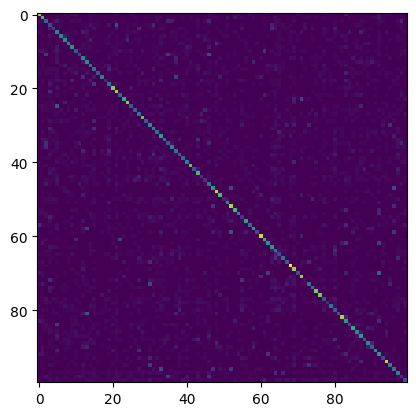

In [ ]:
plt.imshow(cm)

# Hierarchical Softmax

In [ ]:
class HierarchicalSoftmax(tf.keras.layers.Layer):
    def __init__(self, num_classes, tree_structure, name=None):
        super(HierarchicalSoftmax, self).__init__(name=name)
        self.num_classes = num_classes
        self.tree_structure = tree_structure
        self.num_internal_nodes = len(tree_structure) - num_classes
        self.internal_nodes = [tf.Variable(tf.random.normal([1])) for _ in range(self.num_internal_nodes)]
        self.leaf_nodes = [tf.Variable(tf.random.normal([1, num_classes])) for _ in range(num_classes)]
        self.tfp_dist = tfp.distributions.Categorical

    def call(self, inputs):
        probabilities = []
        for i in range(self.num_classes):
            current_node = i + self.num_internal_nodes
            prob = tf.sigmoid(self.internal_nodes[self.tree_structure[current_node][0]] * inputs + self.internal_nodes[self.tree_structure[current_node][1]])
            while current_node > 0:
                parent_node = (current_node - 1) // 2
                if current_node == self.tree_structure[parent_node][0]:
                    prob *= tf.sigmoid(self.internal_nodes[parent_node][0])
                else:
                    prob *= tf.sigmoid(-self.internal_nodes[parent_node][0])
                current_node = parent_node
            probabilities.append(prob * tf.sigmoid(self.leaf_nodes[i][0]))
        return tf.reduce_sum(tf.concat(probabilities, axis=1), axis=1)


In [ ]:
struct = [[i+j for j in range(5)] for i in range(0,20)]

In [ ]:
def functional_model():
  inputs = layers.Input(shape=(32, 32, 3))
  x = layers.Conv2D(32, (3, 3), activation="relu")(inputs)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Conv2D(64, (3, 3), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation="relu")(x)
  outputs = layers.Dense(100, activation=HierarchicalSoftmax(5, struct))(x)
  return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compile and train
model = functional_model()
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_test, y_test), callbacks=[TimeHistory()])

StagingError: ignored

In [ ]:
# Predict the classes of the test set
y_pred = model.predict(x_test)
y_pred_classes = tf.argmax(y_pred, axis=1)
y_true_classes = tf.argmax(y_test, axis=1)

# Compute evaluation metrics
acc = accuracy_score(y_true_classes, y_pred_classes)
prec = precision_score(y_true_classes, y_pred_classes, average='micro')
rec = recall_score(y_true_classes, y_pred_classes, average='micro')
f1 = f1_score(y_true_classes, y_pred_classes, average='micro')
cm = confusion_matrix(y_true_classes, y_pred_classes)

313/313 [==============================] - 1s 2ms/step


In [ ]:
#average training time per epoch
history.history['mean_epoch_time'][-1] 

4.5900955438613895

In [ ]:
acc, prec, rec, f1

(0.3792, 0.3792, 0.3792, 0.37920000000000004)